# Basic Project: Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import time 
import numpy as np
from torchvision.transforms import RandAugment
import random 
import PIL
import pandas as pd
import ast


Tic() Toc() Functions to track training time

In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        return time.time() - startTime_for_tictoc
        #print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        

In [3]:
data_root = "datasets"


Download ResNet18

In [4]:
# for ResNet18:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Dataset

In [5]:
trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='binary-category',
        transform=transform,
        download=False
    )
test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types='binary-category',
        transform=transform,
        download=False
    )


Train / Test Dataset Split

In [6]:
val_ratio = 0.2  # 20% for validation
train_size = int((1 - val_ratio) * len(trainval_data))
val_size = len(trainval_data) - train_size

train_data, val_data = random_split(trainval_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# for data augmentation, save training indices to apply augmentation to the correct images
train_indices_bc = train_data.indices

Visualize 10 random images

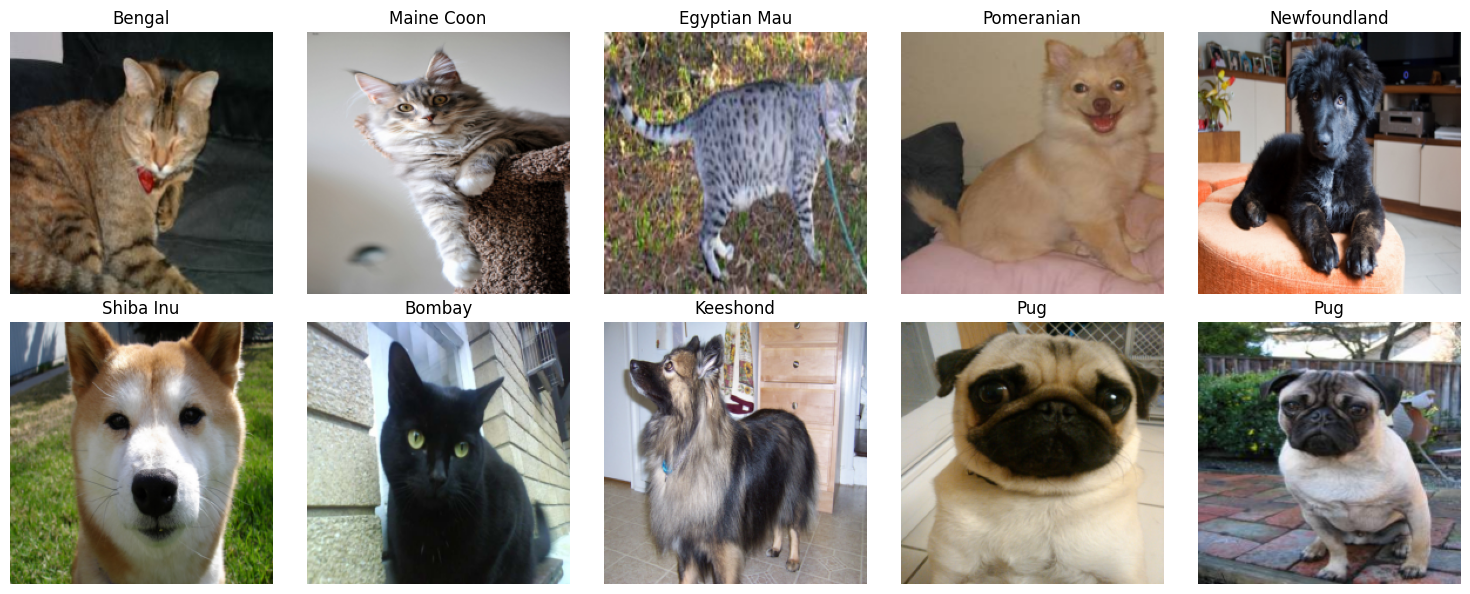

In [7]:
len(val_data), len(train_data), len(test_data)

visualize_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='category',
        transform=transform,
        download=False
    )
images2vis, _ = random_split(visualize_dataset, [train_size, val_size])

def de_normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(img_tensor, tuple):
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.clone() # avoid modifying the original tensor
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def VisImages(data):
    
    # Randomly select 10 indices
    indices = random.sample(range(len(data)), 10)

    # Extract the corresponding images and labels
    images = [de_normalize(data[i][0]) for i in indices]
    labels = [data.dataset.classes[data[i][1]] for i in indices]

    # Convert tensors to PIL images
    images = [F.to_pil_image(img) for img in images]

    # Display the images and labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for ax, img, label in zip(axes.flatten(), images, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{label}")
    plt.tight_layout()
    plt.show()


# Visualize 
VisImages(images2vis)


Data Loaders

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [9]:
dataloaders = {}
dataset_sizes = {}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader
dataloaders['test'] = test_loader

dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)


Initialize the Network

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("If GPU is available: \npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print("Restart the kernel and run the code again.")
    print("Check with `print(torch.cuda.is_available())`")
    print("Documentation: https://pytorch.org/get-started/locally/")
    
# ResNet18
init_network = models.resnet18(weights='DEFAULT')
nf = init_network.fc.in_features
init_network.fc = nn.Linear(nf, 2)

# Freeze all parameters
for param in init_network.parameters():
    param.requires_grad = False

# Unfreeze only the final layer
for param in init_network.fc.parameters():
    param.requires_grad = True

init_network = init_network.to(device)


Using device: mps


Define transformation to apply for data augmentation and return training set with applied augmentation on the training images. Each time the function is called a different augmentation is returned.

In [11]:
def get_augmented_train_dataset(train_indices):
    augment_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet
                             std=[0.229, 0.224, 0.225])
    ])
    return Subset(
        datasets.OxfordIIITPet(
            root=data_root,
            split='trainval',
            target_types='category',
            transform=augment_transform
        ),
        train_indices
    )

Function to Train the Network

In [12]:
def train_network(network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25, data_augmentation = False, train_indices = None):
    if data_augmentation: print("training with data augmentation")
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    def evaluate_phase(phase):
        """Helper to evaluate model on a given phase."""
        network.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for X, Y in dataloaders[phase]:
                X = X.to(device)
                Y = Y.to(device)
                S = network(X)
                _, P = torch.max(S, 1)
                loss = criterion(S, Y)

                running_loss += loss.item() * X.size(0)
                running_corrects += torch.sum(P == Y.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float() / dataset_sizes[phase]
        return epoch_loss, epoch_acc.item()

    # Set Starting Time
    tic()

    with TemporaryDirectory() as tempdir:
        best_network_params_path = os.path.join(tempdir, 'best_network_params.pt')

        torch.save(network.state_dict(), best_network_params_path)
        best_acc = 0.0

        # Step 0: Evaluate before training
        print("Step 0 (Before Training)")
        print('-' * 10)
        for phase in ['train', 'val']:
            loss, acc = evaluate_phase(phase)
            if phase == 'train':
                train_losses.append(loss)
                train_accuracies.append(acc)
            else:
                val_losses.append(loss)
                val_accuracies.append(acc)
            print(f'{phase} Loss: {loss:.4f} Acc: {acc:.4f}')
        print()


        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    network.train()

                    if data_augmentation:
                        train_dataset = get_augmented_train_dataset(train_indices)
                        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        dataloaders['train'] = train_loader

                else:
                    network.eval()

                running_loss = 0.0
                running_corrects = 0

                for X, Y in dataloaders[phase]:

                    X = X.to(device)
                    Y = Y.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        S = network(X)
                        _, P = torch.max(S, 1)
                        loss = criterion(S, Y)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * X.size(0)
                    running_corrects += torch.sum(P == Y.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(network.state_dict(), best_network_params_path)

            print()

        print(f'Best val Acc: {best_acc:4f}')

        network.load_state_dict(torch.load(best_network_params_path, weights_only=True))
        
    # Print Time for Training only
    el_time_training = toc()
    print(f"\nTime for training: {el_time_training:.1f} sec.")
    
    # Return Network and Training Statistics
    train_stats = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'elapsed_time': el_time_training,
    }
    
    return network, train_stats
    # return network, train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
def compute_accuracy(network, loader, print_result=True):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            S = network(X)
            _, P = torch.max(S, 1)
            correct += (P == Y).sum().item()
            total += Y.size(0)

    acc = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {acc:.2f}%")
        
    return acc


Define Entropy Criterion and the Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
lam = 0.0001
optimizer = optim.Adam(init_network.parameters(), lr=1e-4, weight_decay=lam)


Train the Network

In [15]:
# Running for n epochs
num_epochs = 100
TrainYN = False
if TrainYN:
    trained_network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=num_epochs, data_augmentation=True, train_indices=train_indices_bc
    )


Plot the Results

In [16]:
def VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(facecolor='white', figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(0, num_epochs)
    # plt.title('Loss over epochs')
    plt.grid()

    #plt.figure(facecolor='white')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim(0, num_epochs)
    #plt.ylim([0.9, 1.02])
    # plt.title('Accuracy over epochs')
    plt.grid()
    plt.show()
    

# Visualize the loss and accuracy of the Network
if TrainYN:    
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)
    compute_accuracy(trained_network, test_loader)
    

## Multi-Class Problem
- Identifying all 37 breeds of Cats & Dogs

In [24]:
def Load_TrainTestData(data_root, target_types, transform, imbalanced_classes=False, reduction_ratio=0.2):
    rng_imbalance = np.random.default_rng(42)

    trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=transform,
        download=False
    )

    val_ratio = 0.2  # 20% for validation
    train_size = int((1 - val_ratio) * len(trainval_data))
    val_size = len(trainval_data) - train_size

    train_data, val_data = random_split(trainval_data, [train_size, val_size],
    generator=torch.Generator().manual_seed(42))

    if imbalanced_classes:
        # Get target: 0 = cat, 1 = dog
        cat_indices = []
        dog_indices = []

        for i in range(len(train_data)):
            _, label = train_data[i]
            if label == 0:
                cat_indices.append(i)
            else:
                dog_indices.append(i)

        # Subsample cats to 20%
        reduced_cat_indices = rng_imbalance.choice(cat_indices, int(len(cat_indices) * reduction_ratio), replace=False)

        # Combine reduced cats and all dogs
        final_indices = list(reduced_cat_indices) + dog_indices
        train_data = torch.utils.data.Subset(train_data, final_indices)

    
    return train_data, val_data, test_data

def ComputeWeights(dataset, num_classes):
    targets = [dataset[i][1] for i in range(len(dataset))]
    class_counts = np.bincount(targets, minlength=num_classes)
    weights = 1.0 / (class_counts + 1e-5)
    return weights

def DataLoaderFnc(train_data, val_data, test_data, batch_size=32, use_sampler=False, num_classes=None):

    # Create DataLoaders
    if use_sampler and num_classes is not None:
        weights = ComputeWeights(train_data, num_classes)
        sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_data), replacement=True)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    dataloaders = {}
    dataset_sizes = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    dataloaders['test'] = test_loader

    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)

    # only for data augmentation
    train_indices = train_data.indices
    
    return dataloaders, dataset_sizes, train_indices


def Initialize_ResNet18(no_target_classes=2):
    network = models.resnet18(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network

def Initialize_ResNet34(no_target_classes=2):
    network = models.resnet34(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network

def Initialize_ResNet50(no_target_classes=2):
    network = models.resnet50(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    return network



Build one big Training Function

In [25]:
def TrainResNet18_S1(data_root, target_types, transform, TrainParams):
    """
    function for fine-tuning ResNet18
    Train L layers simultaneously, e.g. L = 5 --> train last 5 layers
    """
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    L = TrainParams.get('L', 0)  # Number of layers to fine-tune simultaneously
    strategy = TrainParams.get('strategy', 'fine-tune')  # 'fine-tune' or 'un-freeze'
    data_augmentation = TrainParams.get('data_augmentation', False)
    model_type = TrainParams.get('model_type', 'ResNet18')
    lam = TrainParams.get('lambda', 0)

    imbalanced_classes = TrainParams.get('imbalanced_classes', False)
    use_weighted_loss = TrainParams.get('use_weighted_loss', False)
    use_sampler = TrainParams.get('use_sampler', False)
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform, imbalanced_classes=imbalanced_classes)

    # Create DataLoaders
    dataloaders, dataset_sizes, train_indices = DataLoaderFnc(train_data, val_data, test_data, batch_size, use_sampler, num_classes=no_target_classes)

    # Initialize ResNet
    if model_type == 'ResNet18':
        init_network = Initialize_ResNet18(no_target_classes)
    elif model_type == 'ResNet34':
        init_network = Initialize_ResNet34(no_target_classes)
    elif model_type == 'ResNet50':
        init_network = Initialize_ResNet50(no_target_classes)
        

    # Freeze/Unfreeze Layers, access layers by init_network.children() as this will give the parameters of the specific layers (opposed to init_network.parameters()) 
    if strategy == 'fine-tune':
        for l, (name, module) in enumerate(reversed(list(init_network.named_children()))):
            # amount of parameters that require gradient, if = 0 consider the next layer
            trainable = [p for p in init_network.parameters() if p.requires_grad]
            if len(trainable) == 0 and l <= L: # layer has no params to train and was scheduled to be trained
                print(f"layer {l}: {name} has no params to train, training next layer") 
                L += 1 # add next layer

            # freeze/ unfreeze layers
            if l <= L:
                print(f"train layer {l}: {name}")
                for p in module.parameters(): p.requires_grad = True
            else:
                for p in module.parameters(): p.requires_grad = False


    # Define the loss function and optimizer
    if use_weighted_loss:
        weights = ComputeWeights(train_data, no_target_classes)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr, weight_decay=lam)
    
    # Train the network
    network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs, data_augmentation, train_indices
    )

    # Visualize the loss and accuracy of the Network
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    
    final_acc = compute_accuracy(network, dataloaders['test'], print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc
    
    return network, train_stats
    

### Strategy 1: Fine-tune $l$ layers simultaneously (including imbalanced classes)

In [29]:
# Layers to unfreeze / train
layers = [1, 2, 3, 4, 5, 6, 7, 8]

# Training Parameters
TrainParams = {
    'model_type': 'ResNet18',
    'batch_size': 32,
    'num_epochs': 10,
    'no_target_classes': 37,
    'lr': 1e-4,
    'L': 0,  # Unfreeze the last layer
    'strategy': 'fine-tune',  # 'fine-tune' or 'un-freeze'
    'data_augmentation': True,
    'lambda': 0.0001,
    'use_imbalanced': False,
    'use_weighted_loss': False,
    'use_sampler': False,
}


# Loop through the layers and train the network
train_stats_list = []
TrainYN = False
if TrainYN:
    for l in layers:
        print(f"\nTraining with fine-tuning layers up to layer {l}...")
        TrainParams['L'] = l  # Set the number of layers to fine-tune
        _, train_stats_S1 = TrainResNet18_S1(data_root, 'category', transform, TrainParams)
        print(f"Finished training with fine-tuning layers up to layer {l}.")
        train_stats_list.append(train_stats_S1)


### Strategy 2: Gradual un-freezing

In [ ]:
def TrainResNet18_S2(data_root, target_types, transform, TrainParams):
    
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    data_augmentation = TrainParams.get('data_augmentation', False)
    model_type = TrainParams.get('model_type', 'ResNet18')
    lam = TrainParams.get('lambda', 0)
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes, train_indices = DataLoaderFnc(train_data, val_data, test_data, batch_size)

    # Initialize ResNet
    if model_type == 'ResNet18':
        init_network = Initialize_ResNet18(no_target_classes)
    elif model_type == 'ResNet34':
        init_network = Initialize_ResNet34(no_target_classes)
    elif model_type == 'ResNet50':
        init_network = Initialize_ResNet50(no_target_classes)
    
    
    # Freeze/Unfreeze Layers
    network = init_network
    list_train_stats = []
    print("\nStart Training Network (Strategy: gradually unfreeze layers) ...")
    
    # current layer to be unfreezed, start with the last layer
    for layer, (name, _) in enumerate(reversed(list(init_network.named_children()))):
    
        # Freeze / unfreeze the right layers (gradually unfreeze)
        for l, (_, module) in enumerate(reversed(list(init_network.named_children()))):
            for p in module.parameters(): p.requires_grad = False # freeze all layers
            
            if l == layer: # unfreeze the current layer
                for p in module.parameters(): p.requires_grad = True
            
        
        # amount of parameters that require gradient, if = 0 skip the layer
        trainable = [p for p in network.parameters() if p.requires_grad]
        if len(trainable) == 0:
            print(f"Layer {layer}: {name} has no trainable parameters. Skipping...")
            continue

        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(init_network.parameters(), lr, weight_decay=lam)

        # Train the network (only the unfreezed layers)
        print("------------------------------------------")
        print(f"\nTraining with unfreezing layer {layer}: {name}...")
        network, train_stats = train_network(
            network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs, data_augmentation, train_indices
        )
        list_train_stats.append(train_stats)


        # Visualize the loss and accuracy of the Network
        train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
        VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, dataloaders['test'], print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc
    
    return network, train_stats, list_train_stats
    
    

In [ ]:
### ONLY for plotting

# Load the CSV file into a DataFrame
file_path = "list_train_stats.csv" 
file_path_S2 = "train_stats_S2.csv"  
data_raw = pd.read_csv(file_path)
data_S2 = pd.read_csv(file_path_S2)
data = data_raw.copy()
train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []

data['train_losses'] = data['train_losses'].apply(ast.literal_eval)
data['val_losses'] = data['val_losses'].apply(ast.literal_eval)
data['train_accuracies'] = data['train_accuracies'].apply(ast.literal_eval)
data['val_accuracies'] = data['val_accuracies'].apply(ast.literal_eval)

for i in range(data.shape[0]): # no of layers = 7
        for j in range(len(data['train_losses'][0])): # no of data points per trained layer = 26
            train_loss_list.append(data['train_losses'][i][j])
            val_loss_list.append(data['val_losses'][i][j])
            train_acc_list.append(data['train_accuracies'][i][j])
            val_acc_list.append(data['val_accuracies'][i][j])

plt.figure(facecolor='white', figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
x_lines = [26, 52, 78, 104, 130, 156, 182]
for x_pos in x_lines:
    plt.axvline(x=x_pos, color='gray', linestyle=':', linewidth=1)
tick_positions = [13 + 26 * i for i in range(7)]  # [0, 26, 52, ..., 156]
tick_labels = ["Layer 0", "Layer 2", "Layer 3", "Layer 4", "Layer 5", "Layer 8", "Layer 9"]
plt.xticks(tick_positions, tick_labels, rotation=0)
plt.tick_params(axis='x', length=0)
plt.legend()
plt.ylabel('Loss')
plt.xlim(0, 182)
plt.ylim([-0.2, 3])
plt.title('Loss over trained layer')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
#x_lines = [25, 50, 75, 100, 125, 150]
x_lines = [26, 52, 78, 104, 130, 156, 182]
for x_pos in x_lines:
    plt.axvline(x=x_pos, color='gray', linestyle=':', linewidth=1)
tick_positions = [13 + 26 * i for i in range(7)]  # [0, 26, 52, ..., 156]
tick_labels = ["Layer 0", "Layer 2", "Layer 3", "Layer 4", "Layer 5", "Layer 8", "Layer 9"]
plt.xticks(tick_positions, tick_labels, rotation=0)
plt.tick_params(axis='x', length=0)
plt.legend()
plt.ylabel('Accuracy')
plt.xlim(0, 182)
plt.ylim([0.6, 1.05])
plt.title('Accuracy over trained layer')
plt.show()

In [ ]:
# Training Parameters
TrainParams = {
    'model_type': 'ResNet18',
    'batch_size': 32,
    'num_epochs': 25,
    'no_target_classes': 37,
    'lr': 1e-4,
    'strategy': 'un-freeze',  # 'fine-tune' or 'un-freeze'
    'data_augmentation': True,
    'lambda': 0.0001
}

TrainYN = False

for lam in [0.001, 0.0001, 0.00001]:

    TrainParams['lambda'] = lam
    # Train the network with gradually unfreezing layers
    if TrainYN:
        trained_net_S2, train_stats_S2, list_train_stats = TrainResNet18_S2(data_root, 'category', transform, TrainParams)
    
    train_stats_df = pd.DataFrame([train_stats_S2])
    train_stats_df.to_csv(f"train_stats_S2_{lam}.csv", index=False)

    list_train_stats_df = pd.DataFrame(list_train_stats)
    list_train_stats_df.to_csv(f"list_train_stats_{lam}.csv", index=False)

    print("Training statistics saved to train_stats_S2.csv and list_train_stats.csv")


# Extend basic project --> B/A
- FixMatch
- https://github.com/google-research/fixmatch/blob/master/pseudo_label.py


### Data Augmentation
- weak augmentation
- strong augmentation

In [ ]:
def get_strong_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),
        RandAugment(num_ops=2, magnitude=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_weak_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet normalization
                             std=[0.229, 0.224, 0.225])
    ])


class TransformFixMatch:
    """Applies weak and strong augmentation to the same input image."""
    def __init__(self, image_size=224):
        self.weak = get_weak_augmentation(image_size)
        self.strong = get_strong_augmentation(image_size)

    def __call__(self, x):
        weak_aug = self.weak(x)
        strong_aug = self.strong(x)
        return weak_aug, strong_aug


# Example usage
transform = TransformFixMatch(image_size=224)
image = PIL.Image.open('datasets/oxford-iiit-pet/images/Abyssinian_1.jpg')
weak_aug, strong_aug = transform(image)
# Visualize the augmentations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.asarray(image))
axes[0].set_title('Original Image')
axes[1].imshow(weak_aug.permute(1, 2, 0).numpy())
axes[1].set_title('Weak Augmentation')
axes[2].imshow(strong_aug.permute(1, 2, 0).numpy())
axes[2].set_title('Strong Augmentation')
plt.show()


Test the TransformFixMatch class (Visualize the Augmentation)

In [ ]:
image_size = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Define transforms
weak_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
strong_transform = TransformFixMatch(image_size)  # RandAugment included

# Print the transformations
#print("Weak Transformations:", weak_transform)
#print("Strong Transformations:", strong_transform.strong)

# Extract # random pictures from the dataset
no_pictures = 10
ran_indices = random.sample(range(len(images2vis)), no_pictures)

# Extract the images and labels
ran_images = [de_normalize(images2vis[i][0]) for i in ran_indices]
labels = [images2vis.dataset.classes[images2vis[i][1]] for i in ran_indices]
images_raw = [F.to_pil_image(img) for img in ran_images]


# Apply the transformations to the dataset
images_weakaug = [de_normalize(weak_transform(img)) for img in images_raw]
images_weakaug = [F.to_pil_image(img) for img in images_weakaug]
images_strongaug = [de_normalize(strong_transform(img)[1]) if isinstance(strong_transform(img), tuple) \
    else strong_transform(img) for img in images_raw]
images_strongaug = [F.to_pil_image(img) for img in images_strongaug]

# Visualize the weak and strong augmentations
fig, axes = plt.subplots(3, no_pictures+1, figsize=(20, 5))  # 3 rows, 6 columns (1 for labels, 5 for images)

# Add row labels
row_labels = ["Raw Image:", "Weak Aug:", "Strong Aug:"]
for row, label in enumerate(row_labels):
    axes[row, 0].text(0.5, 0.5, label, fontsize=20, ha='center', va='center')
    axes[row, 0].axis('off')

# Add images and headers
for col, (raw, weak, strong, label) in enumerate(zip(images_raw, images_weakaug, images_strongaug, labels), start=1):
    # First row: raw images with headers
    axes[0, col].imshow(raw)
    axes[0, col].set_title(label, fontsize=12)
    axes[0, col].axis('off')

    # Second row: weak augmentations
    axes[1, col].imshow(weak)
    axes[1, col].axis('off')

    # Third row: strong augmentations
    axes[2, col].imshow(strong)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()


### Perpare the Dataset
- Split labelled / unlabelled dataset

In [ ]:
def split_labeled_unlabeled(dataset, num_labels_per_class, num_classes, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set random seed for reproducibility
    
    # Access the labels
    try:
        targets = np.array(dataset.targets)  # Use targets attribute if available
    except AttributeError:
        targets = np.array([dataset[i][1] for i in range(len(dataset))])  # Fallback to accessing each sample
    
    labeled_indices = []
    unlabeled_indices = []
    
    for class_idx in range(num_classes):
        class_indices = np.where(targets == class_idx)[0]
        if len(class_indices) < num_labels_per_class:
            raise ValueError(f"Class {class_idx} has fewer samples than num_labels_per_class.")
        
        np.random.shuffle(class_indices)
        labeled_indices.extend(class_indices[:num_labels_per_class])
        unlabeled_indices.extend(class_indices[num_labels_per_class:])
    
    return np.array(labeled_indices), np.array(unlabeled_indices)


def load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeld=32, batch_size_unlabeld=64, image_size=224, seed=None):
    # Common normalization values for ImageNet (can fine-tune later)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
        
    # Define transforms
    transform_FixMatch = TransformFixMatch(image_size)
    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize
    ])
        
    
    # Load the full dataset
    full_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    
    test_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=val_test_transform,
        download=False
    )
    
    # Split into labeled and unlabeled data
    labeled_indices, unlabeled_indices = split_labeled_unlabeled(full_dataset, num_labels_per_class, num_classes, seed=seed)
    
    # Create labeled and unlabeled datasets
    labeled_dataset = Subset(full_dataset, labeled_indices)
    unlabeled_dataset = Subset(full_dataset, unlabeled_indices)
    
    # Apply transforms
    labeled_dataset.dataset.transform = transform_FixMatch.weak # Use only weak augmentation for labeled data
    unlabeled_dataset.dataset.transform = transform_FixMatch    # Use both weak and strong augmentations for unlabeled data
    
    # Optional: make a validation split out of labeled set
    val_ratio = 0.2
    val_size = int(val_ratio * len(labeled_dataset))
    train_size = len(labeled_dataset) - val_size
    labeled_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])
    
    # Dictionary to hold DataLoaders
    dataloaders = {
        'labeled': DataLoader(labeled_dataset, batch_size=batch_size_labeld, shuffle=True),
        'unlabeled': DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeld, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size_labeld, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=batch_size_labeld, shuffle=False)
    }
    
    return dataloaders


### Loss Function

In [ ]:
def compute_fixmatch_loss(logits_x, targets_x, logits_u_w, logits_u_s, threshold=0.95, lambda_u=1.0):

    
    # Supervised loss
    criterion = nn.CrossEntropyLoss(reduction='mean')
    loss_x = criterion(logits_x, targets_x)
    
    # Generate pseudo labels from weakly augmented unlabeled data
    pseudo_labels = torch.softmax(logits_u_w, dim=-1)
    max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
    
    # Mask to select high-confidence pseudo-labels
    mask = max_probs.ge(threshold).float()
    
    # Unsupervised loss (only for confident predictions)
    unsupervised_criterion = nn.CrossEntropyLoss(reduction='none')
    loss_u = (unsupervised_criterion(logits_u_s, targets_u) * mask).mean()
    
    # Total loss
    total_loss = loss_x + lambda_u * loss_u
    
    return total_loss, loss_x, loss_u


### Training Loop

In [ ]:
def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, device, epoch, lambda_u=1.0, threshold=0.95):
    model.train()

    # Track losses
    running_loss = 0.0
    running_supervised_loss = 0.0
    running_unsupervised_loss = 0.0

    unlabeled_iter = iter(unlabeled_loader)

    for batch_idx, (inputs_x_ws, targets_x) in enumerate(labeled_loader):
        try:
            # Correctly unpack the unlabeled data
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch  # Unpack images and ignore labels
            inputs_u_w, inputs_u_s = inputs_u  # Unpack weak and strong augmentations
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch
            inputs_u_w, inputs_u_s = inputs_u

        # Move data to device (GPU or CPU)
        inputs_x, _ = inputs_x_ws # Unpack images (weak and strong augmentations) - Size: [batch_size, 3, 224, 224]
        inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
        inputs_u_w, inputs_u_s = inputs_u_w.to(device), inputs_u_s.to(device)

        # Get batch size
        batch_size = inputs_x.size(0)

        # Forward pass
        logits_x = model(inputs_x)
        logits_u_w = model(inputs_u_w)
        logits_u_s = model(inputs_u_s)

        # Compute FixMatch loss
        total_loss, loss_x, loss_u = compute_fixmatch_loss(
            logits_x, targets_x, logits_u_w, logits_u_s,
            threshold=threshold, lambda_u=lambda_u
        )

        # Optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Statistics
        running_loss += total_loss.item()
        running_supervised_loss += loss_x.item()
        running_unsupervised_loss += loss_u.item()

        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx}] "
                  f"Loss: {total_loss.item():.4f} "
                  f"Supervised Loss: {loss_x.item():.4f} "
                  f"Unsupervised Loss: {loss_u.item():.4f}")

    epoch_loss = running_loss / len(labeled_loader)
    epoch_supervised_loss = running_supervised_loss / len(labeled_loader)
    epoch_unsupervised_loss = running_unsupervised_loss / len(labeled_loader)

    return epoch_loss, epoch_supervised_loss, epoch_unsupervised_loss


### Evaluation

In [ ]:
def accuracy(output, target, topk=(1,5)):
    """Computes the top-k accuracy"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # Top-k predictions
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def evaluate(model, dataloader, device):
    model.eval()
    
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            if isinstance(inputs, list):
                inputs = inputs[0]
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # Compute top-k accuracies
            top1, top5 = accuracy(outputs, targets, topk=(1, 5))
            
            top1_correct += top1.item() * inputs.size(0) / 100.0
            top5_correct += top5.item() * inputs.size(0) / 100.0
            total += inputs.size(0)
    
    top1_acc = 100.0 * top1_correct / total
    top5_acc = 100.0 * top5_correct / total

    print(f"Validation Top-1 Accuracy: {top1_acc:.2f}% | Top-5 Accuracy: {top5_acc:.2f}%")
    
    return top1_acc, top5_acc


Function to Visualize images from Dataloaders (for debugging)

In [ ]:
# Visualize a batch of images
def visualize_dataloader(dataloader, num_images=8):
    # Get a batch of data
    images, labels = next(iter(dataloader))
    
    # Extract images and labels
    print(f"Type of images: {type(images)}")
    print(f"Type of labels: {type(labels)}")
    if isinstance(images, list):
        images = images[0]  # Use only the weakly augmented images
    
    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = de_normalize(images[i])
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()


### Full Training Script
- Possibility to "speed-up": If more training is necessary:
    - Since the best model is saved at every epoch (if it is better then the previous of course)
    - then it can be loaded again (instead of initialization)
    - and training can be proceeded

    **--> be careful with number of labeled labels though!**

    **FixMatch strongly depends on the labeled images used! (Is also stated in the Google Paper)**
    **This effect, is even more present, if less labeled samples are used.**
        - I would suggest to define the learning strategies from all the studies above (basic assignment) and then apply it to the FixMatch algorithm
        - Run the code a few times (would be good to define lets say 3 or 5 seeds) and report the average test accuracy and std
        - Try e.g. 1, 4, 16, 40 labeled images per class --> a minimum number of labeled samples is therefore obtained

In [ ]:
# Visualize Trend of Top-1 and Top-5 Accuracy
def visualize_accuracy_trend(top1_list, top5_list):
    plt.figure(figsize=(12, 6))
    plt.plot(top1_list, label='Top-1 Accuracy', marker='o')
    plt.plot(top5_list, label='Top-5 Accuracy', marker='o')
    plt.title('Top-1 and Top-5 Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()
    plt.show()
    
# Visualize Loss Trend
def visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list):
    plt.figure(figsize=(12, 6))
    plt.plot(loss_list, label='Total Loss', marker='o')
    plt.plot(supervised_loss_list, label='Supervised Loss', marker='o')
    plt.plot(unsupervised_loss_list, label='Unsupervised Loss', marker='o')
    plt.title('Loss Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()



def FixMatch_Train(model_type, num_labels_per_class, num_epochs, seed):

    # Configuration
    data_root = "datasets"
    target_types = 'category'
    num_classes = 37  # Pet dataset (all breeds)
    #num_labels_per_class = 16  # Number of labeled samples per class
        # = 4: Tobi: 79min 25sec training time
        # = 40: Tobi: 1120min training time

    image_size = 224
    batch_size_labeled = 32
    batch_size_unlabeled = batch_size_labeled*5 # 5x more than labeled, typical for FixMatch
    #num_epochs = 30
    threshold = 0.95
    lambda_u = 1.0  # weight for unlabeled loss
    #device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device.type == 'cpu'

    # Initialize ResNet
    if model_type == 'ResNet18':
        model = Initialize_ResNet18(num_classes)
    elif model_type == 'ResNet34':
        model = Initialize_ResNet34(num_classes)
    elif model_type == 'ResNet50':
        model = Initialize_ResNet50(num_classes)
    else:
        print("Implement something `here` to load best model from previous training run.")


    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    # Data Loaders - here is the randomness!
    dataloaders = load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeled, batch_size_unlabeled, image_size, seed)
    labeled_loader = dataloaders['labeled']
    unlabeled_loader = dataloaders['unlabeled']
    validation_loader = dataloaders['val']
    test_loader = dataloaders['test']

    # Visualize images from the Dataloaders
    debugYN = False
    if debugYN:
        print("\n--- Labeled Data ---")
        visualize_dataloader(dataloaders['labeled'], 10)
        print("\n--- Unlabeled Data ---")
        visualize_dataloader(dataloaders['unlabeled'], 10)
        print("\n--- Validation Data ---")
        visualize_dataloader(dataloaders['val'], 10)
        print("\n--- Test Data ---")
        visualize_dataloader(dataloaders['test'], 10)

    top1_list = []
    top5_list = []
    loss_list = []
    supervised_loss_list = []
    unsupervised_loss_list = []

    # Training Loop
    best_top1 = 0.0
    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")

        # Train
        train_loss, train_supervised_loss, train_unsupervised_loss = train_fixmatch(
            model, labeled_loader, unlabeled_loader, optimizer, device, epoch,
            lambda_u=lambda_u, threshold=threshold
        )

        print(f"Train Loss: {train_loss:.4f} | Supervised: {train_supervised_loss:.4f} | Unsupervised: {train_unsupervised_loss:.4f}")
        loss_list.append(train_loss)
        supervised_loss_list.append(train_supervised_loss)
        unsupervised_loss_list.append(train_unsupervised_loss)

        # Evaluate
        val_top1, val_top5 = evaluate(model, validation_loader, device)
        top1_list.append(val_top1)
        top5_list.append(val_top5)

        # Save best model
        if val_top1 > best_top1:
            best_top1 = val_top1
            torch.save(model.state_dict(), f"best_fixmatch_{model_type}_model_{num_labels_per_class}labels_{seed}seed.pth")
            print("Saved new best model!")
        else:
            print("No improvement, not saving model.")        
            
    return model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list


# Run the FixMatch training
TrainYN = False
if TrainYN:
    model_type = 'ResNet18'  # Choose between 'ResNet18', 'ResNet34', or 'ResNet50'
    seed_list = [1, 2, 3]
    num_labels_per_class = 4
    num_epochs = 15
    test_top1_list = []
    test_top5_list = []
    for seed in seed_list:
        model, loss_list, supervised_loss_list, unsupervised_loss_list, top1_list, top5_list = FixMatch_Train(model_type, num_labels_per_class, num_epochs, seed)
        
        # Visualize Accuracy and Loss Trends
        visualize_accuracy_trend(top1_list, top5_list)
        visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list)
            
        # Get Test Accuracy with best model
        model.load_state_dict(torch.load(f"best_fixmatch_{model_type}_model_{num_labels_per_class}labels_{seed}seed.pth"))
        test_top1, test_top5 = evaluate(model, dataloaders['test'], device)
        print(f"\nTest Top-1 Accuracy: {test_top1:.2f}% | Test Top-5 Accuracy: {test_top5:.2f}%")
        
        test_top1_list.append(test_top1)
        test_top5_list.append(test_top5)
        

        # Save the loss, top-1 and top-5 list to csv file
        filename = f'fixmatch_training_stats_{model_type}model_{num_labels_per_class}labels_{seed}seed.csv'
        df = pd.DataFrame({
            'Epoch': range(1, num_epochs + 1),
            'Top-1 Accuracy': top1_list,
            'Top-5 Accuracy': top5_list,
            'Total Loss': loss_list,
            'Supervised Loss': supervised_loss_list,
            'Unsupervised Loss': unsupervised_loss_list,
            'Test Top-1 Accuracy': test_top1,
            'Test Top-5 Accuracy': test_top5,
        })
        
        # Check if the file already exists
        if os.path.exists(filename):
            # Append to the existing file
            df.to_csv(filename, mode='a', header=False, index=False)
        else:
            # Create a new file
            df.to_csv(filename, index=False)
            
            
        # Print final Test Accuracy with Standard Deviation
        mean_top1 = np.mean(test_top1_list)
        std_top1 = np.std(test_top1_list)
        mean_top5 = np.mean(test_top5_list)
        std_top5 = np.std(test_top5_list)
        print(f"\nFinal Test Top-1 Accuracy: {mean_top1:.2f}% ± {std_top1:.2f}%")
        print(f"Final Test Top-5 Accuracy: {mean_top5:.2f}% ± {std_top5:.2f}%")
        

#### Saved from Learning Network for 10 epochs (180 min)

--- Epoch 1/10 ---
Epoch [1] Batch [0] Loss: 3.9471 Supervised Loss: 3.9471 Unsupervised Loss: 0.0000
Epoch [1] Batch [20] Loss: 2.1357 Supervised Loss: 1.9048 Unsupervised Loss: 0.2310
Train Loss: 2.4848 | Supervised: 2.3746 | Unsupervised: 0.1102
Validation Top-1 Accuracy: 14.86% | Top-5 Accuracy: 46.28%
Saved new best model!

--- Epoch 2/10 ---
Epoch [2] Batch [0] Loss: 1.9900 Supervised Loss: 1.8160 Unsupervised Loss: 0.1740
Epoch [2] Batch [20] Loss: 3.2791 Supervised Loss: 3.2272 Unsupervised Loss: 0.0519
Train Loss: 2.9669 | Supervised: 2.8571 | Unsupervised: 0.1098
Validation Top-1 Accuracy: 15.20% | Top-5 Accuracy: 47.64%
Saved new best model!

--- Epoch 3/10 ---
Epoch [3] Batch [0] Loss: 2.3836 Supervised Loss: 2.3728 Unsupervised Loss: 0.0108
Epoch [3] Batch [20] Loss: 2.5582 Supervised Loss: 2.3905 Unsupervised Loss: 0.1677
Train Loss: 2.4857 | Supervised: 2.3802 | Unsupervised: 0.1055
Validation Top-1 Accuracy: 26.69% | Top-5 Accuracy: 69.26%
Saved new best model!

--- Epoch 4/10 ---
Epoch [4] Batch [0] Loss: 3.1559 Supervised Loss: 3.0505 Unsupervised Loss: 0.1054
Epoch [4] Batch [20] Loss: 1.5976 Supervised Loss: 1.3893 Unsupervised Loss: 0.2083
Train Loss: 1.9308 | Supervised: 1.7513 | Unsupervised: 0.1795
Validation Top-1 Accuracy: 31.42% | Top-5 Accuracy: 72.64%
Saved new best model!

--- Epoch 5/10 ---
Epoch [5] Batch [0] Loss: 2.4420 Supervised Loss: 2.1580 Unsupervised Loss: 0.2839
Epoch [5] Batch [20] Loss: 1.0752 Supervised Loss: 0.9148 Unsupervised Loss: 0.1604
Train Loss: 1.3770 | Supervised: 1.1924 | Unsupervised: 0.1846
Validation Top-1 Accuracy: 43.24% | Top-5 Accuracy: 78.38%
Saved new best model!

--- Epoch 6/10 ---
Epoch [6] Batch [0] Loss: 1.5669 Supervised Loss: 1.2905 Unsupervised Loss: 0.2764
Epoch [6] Batch [20] Loss: 1.1614 Supervised Loss: 0.9400 Unsupervised Loss: 0.2214
Train Loss: 1.3390 | Supervised: 1.1382 | Unsupervised: 0.2008
Validation Top-1 Accuracy: 47.64% | Top-5 Accuracy: 79.39%
Saved new best model!

--- Epoch 7/10 ---
Epoch [7] Batch [0] Loss: 0.9391 Supervised Loss: 0.7451 Unsupervised Loss: 0.1940
Epoch [7] Batch [20] Loss: 1.1811 Supervised Loss: 0.9402 Unsupervised Loss: 0.2409
Train Loss: 1.1847 | Supervised: 0.9285 | Unsupervised: 0.2562
Validation Top-1 Accuracy: 46.62% | Top-5 Accuracy: 81.76%
No improvement, not saving model.

--- Epoch 8/10 ---
Epoch [8] Batch [0] Loss: 0.9729 Supervised Loss: 0.8089 Unsupervised Loss: 0.1640
Epoch [8] Batch [20] Loss: 0.5816 Supervised Loss: 0.3195 Unsupervised Loss: 0.2621
Train Loss: 0.8694 | Supervised: 0.6335 | Unsupervised: 0.2359
Validation Top-1 Accuracy: 53.04% | Top-5 Accuracy: 86.82%
Saved new best model!

--- Epoch 9/10 ---
Epoch [9] Batch [0] Loss: 0.6071 Supervised Loss: 0.4218 Unsupervised Loss: 0.1853
Epoch [9] Batch [20] Loss: 1.2063 Supervised Loss: 0.7612 Unsupervised Loss: 0.4451
Train Loss: 0.7340 | Supervised: 0.4695 | Unsupervised: 0.2645
Validation Top-1 Accuracy: 52.03% | Top-5 Accuracy: 86.49%
No improvement, not saving model.

--- Epoch 10/10 ---
Epoch [10] Batch [0] Loss: 0.5246 Supervised Loss: 0.3115 Unsupervised Loss: 0.2130
Epoch [10] Batch [20] Loss: 0.5426 Supervised Loss: 0.2863 Unsupervised Loss: 0.2563
Train Loss: 0.6224 | Supervised: 0.3653 | Unsupervised: 0.2571
Validation Top-1 Accuracy: 59.46% | Top-5 Accuracy: 89.19%
Saved new best model!



### Saved from Learning Network for 30 epochs (1120 min)
--- Epoch 1/30 ---
Epoch [1] Batch [0] Loss: 3.8736 Supervised Loss: 3.8736 Unsupervised Loss: 0.0000
Epoch [1] Batch [20] Loss: 1.7233 Supervised Loss: 1.6408 Unsupervised Loss: 0.0825
Train Loss: 2.4875 | Supervised: 2.3792 | Unsupervised: 0.1084
Validation Top-1 Accuracy: 4.73% | Top-5 Accuracy: 29.73%
Saved new best model!

--- Epoch 2/30 ---
Epoch [2] Batch [0] Loss: 3.6865 Supervised Loss: 3.5388 Unsupervised Loss: 0.1477
Epoch [2] Batch [20] Loss: 2.6268 Supervised Loss: 2.6151 Unsupervised Loss: 0.0117
Train Loss: 3.1425 | Supervised: 3.0523 | Unsupervised: 0.0902
Validation Top-1 Accuracy: 21.96% | Top-5 Accuracy: 54.05%
Saved new best model!

--- Epoch 3/30 ---
Epoch [3] Batch [0] Loss: 2.5924 Supervised Loss: 2.4876 Unsupervised Loss: 0.1048
Epoch [3] Batch [20] Loss: 2.0461 Supervised Loss: 1.9342 Unsupervised Loss: 0.1119
Train Loss: 2.6453 | Supervised: 2.5342 | Unsupervised: 0.1110
Validation Top-1 Accuracy: 25.00% | Top-5 Accuracy: 65.54%
Saved new best model!

--- Epoch 4/30 ---
Epoch [4] Batch [0] Loss: 2.4073 Supervised Loss: 2.2402 Unsupervised Loss: 0.1672
Epoch [4] Batch [20] Loss: 2.4360 Supervised Loss: 2.2563 Unsupervised Loss: 0.1798
Train Loss: 2.0720 | Supervised: 1.9001 | Unsupervised: 0.1718
Validation Top-1 Accuracy: 20.61% | Top-5 Accuracy: 64.19%
No improvement, not saving model.

--- Epoch 5/30 ---
Epoch [5] Batch [0] Loss: 1.6327 Supervised Loss: 1.4678 Unsupervised Loss: 0.1649
Epoch [5] Batch [20] Loss: 1.2737 Supervised Loss: 1.0817 Unsupervised Loss: 0.1919
Train Loss: 1.7122 | Supervised: 1.5182 | Unsupervised: 0.1940
Validation Top-1 Accuracy: 37.16% | Top-5 Accuracy: 77.03%
Saved new best model!

--- Epoch 6/30 ---
Epoch [6] Batch [0] Loss: 1.1685 Supervised Loss: 0.9762 Unsupervised Loss: 0.1923
Epoch [6] Batch [20] Loss: 1.2245 Supervised Loss: 0.9365 Unsupervised Loss: 0.2880
Train Loss: 1.2306 | Supervised: 0.9989 | Unsupervised: 0.2318
Validation Top-1 Accuracy: 47.97% | Top-5 Accuracy: 84.80%
Saved new best model!

--- Epoch 7/30 ---
Epoch [7] Batch [0] Loss: 0.9433 Supervised Loss: 0.8093 Unsupervised Loss: 0.1340
Epoch [7] Batch [20] Loss: 1.0662 Supervised Loss: 0.7543 Unsupervised Loss: 0.3119
Train Loss: 0.9773 | Supervised: 0.7708 | Unsupervised: 0.2065
Validation Top-1 Accuracy: 44.59% | Top-5 Accuracy: 77.03%
No improvement, not saving model.

--- Epoch 8/30 ---
Epoch [8] Batch [0] Loss: 0.7726 Supervised Loss: 0.5455 Unsupervised Loss: 0.2272
Epoch [8] Batch [20] Loss: 0.8409 Supervised Loss: 0.4525 Unsupervised Loss: 0.3883
Train Loss: 0.8694 | Supervised: 0.6291 | Unsupervised: 0.2403
Validation Top-1 Accuracy: 50.00% | Top-5 Accuracy: 86.49%
Saved new best model!

--- Epoch 9/30 ---
Epoch [9] Batch [0] Loss: 0.4127 Supervised Loss: 0.3259 Unsupervised Loss: 0.0868
Epoch [9] Batch [20] Loss: 0.4005 Supervised Loss: 0.1971 Unsupervised Loss: 0.2033
Train Loss: 0.6480 | Supervised: 0.4106 | Unsupervised: 0.2374
Validation Top-1 Accuracy: 56.08% | Top-5 Accuracy: 91.55%
Saved new best model!

--- Epoch 10/30 ---
Epoch [10] Batch [0] Loss: 0.6422 Supervised Loss: 0.3292 Unsupervised Loss: 0.3130
Epoch [10] Batch [20] Loss: 0.3551 Supervised Loss: 0.1424 Unsupervised Loss: 0.2127
Train Loss: 0.5664 | Supervised: 0.3130 | Unsupervised: 0.2533
Validation Top-1 Accuracy: 52.36% | Top-5 Accuracy: 87.50%
No improvement, not saving model.

--- Epoch 11/30 ---
Epoch [11] Batch [0] Loss: 0.5699 Supervised Loss: 0.3514 Unsupervised Loss: 0.2185
Epoch [11] Batch [20] Loss: 0.4310 Supervised Loss: 0.1126 Unsupervised Loss: 0.3184
Train Loss: 0.5214 | Supervised: 0.2715 | Unsupervised: 0.2498
Validation Top-1 Accuracy: 56.08% | Top-5 Accuracy: 92.23%
No improvement, not saving model.

--- Epoch 12/30 ---
Epoch [12] Batch [0] Loss: 0.6357 Supervised Loss: 0.3383 Unsupervised Loss: 0.2974
Epoch [12] Batch [20] Loss: 0.5724 Supervised Loss: 0.3671 Unsupervised Loss: 0.2053
Train Loss: 0.5270 | Supervised: 0.2754 | Unsupervised: 0.2516
Validation Top-1 Accuracy: 56.76% | Top-5 Accuracy: 90.54%
Saved new best model!

--- Epoch 13/30 ---
Epoch [13] Batch [0] Loss: 0.2837 Supervised Loss: 0.0658 Unsupervised Loss: 0.2179
Epoch [13] Batch [20] Loss: 0.4661 Supervised Loss: 0.2340 Unsupervised Loss: 0.2322
Train Loss: 0.4237 | Supervised: 0.1831 | Unsupervised: 0.2406
Validation Top-1 Accuracy: 61.49% | Top-5 Accuracy: 90.88%
Saved new best model!

--- Epoch 14/30 ---
Epoch [14] Batch [0] Loss: 0.2799 Supervised Loss: 0.0393 Unsupervised Loss: 0.2406
Epoch [14] Batch [20] Loss: 0.3266 Supervised Loss: 0.1697 Unsupervised Loss: 0.1569
Train Loss: 0.3888 | Supervised: 0.1614 | Unsupervised: 0.2274
Validation Top-1 Accuracy: 63.85% | Top-5 Accuracy: 91.22%
Saved new best model!

--- Epoch 15/30 ---
Epoch [15] Batch [0] Loss: 0.1836 Supervised Loss: 0.0632 Unsupervised Loss: 0.1203
Epoch [15] Batch [20] Loss: 0.4839 Supervised Loss: 0.2540 Unsupervised Loss: 0.2299
Train Loss: 0.3377 | Supervised: 0.1370 | Unsupervised: 0.2006
Validation Top-1 Accuracy: 64.86% | Top-5 Accuracy: 89.86%
Saved new best model!

--- Epoch 16/30 ---
Epoch [16] Batch [0] Loss: 0.3505 Supervised Loss: 0.0802 Unsupervised Loss: 0.2703
Epoch [16] Batch [20] Loss: 0.2344 Supervised Loss: 0.0694 Unsupervised Loss: 0.1650
Train Loss: 0.3171 | Supervised: 0.1065 | Unsupervised: 0.2107
Validation Top-1 Accuracy: 61.15% | Top-5 Accuracy: 90.20%
No improvement, not saving model.

--- Epoch 17/30 ---
Epoch [17] Batch [0] Loss: 0.0950 Supervised Loss: 0.0136 Unsupervised Loss: 0.0814
Epoch [17] Batch [20] Loss: 0.2724 Supervised Loss: 0.0316 Unsupervised Loss: 0.2408
Train Loss: 0.2763 | Supervised: 0.0874 | Unsupervised: 0.1888
Validation Top-1 Accuracy: 65.20% | Top-5 Accuracy: 89.86%
Saved new best model!

--- Epoch 18/30 ---
Epoch [18] Batch [0] Loss: 0.3213 Supervised Loss: 0.0584 Unsupervised Loss: 0.2629
Epoch [18] Batch [20] Loss: 0.2418 Supervised Loss: 0.1062 Unsupervised Loss: 0.1356
Train Loss: 0.2293 | Supervised: 0.0609 | Unsupervised: 0.1684
Validation Top-1 Accuracy: 68.24% | Top-5 Accuracy: 93.58%
Saved new best model!

--- Epoch 19/30 ---
Epoch [19] Batch [0] Loss: 0.1781 Supervised Loss: 0.0238 Unsupervised Loss: 0.1543
Epoch [19] Batch [20] Loss: 0.3267 Supervised Loss: 0.0818 Unsupervised Loss: 0.2449
Train Loss: 0.2546 | Supervised: 0.0718 | Unsupervised: 0.1828
Validation Top-1 Accuracy: 69.59% | Top-5 Accuracy: 93.92%
Saved new best model!

--- Epoch 20/30 ---
Epoch [20] Batch [0] Loss: 0.1900 Supervised Loss: 0.0152 Unsupervised Loss: 0.1748
Epoch [20] Batch [20] Loss: 0.1728 Supervised Loss: 0.0202 Unsupervised Loss: 0.1527
Train Loss: 0.2210 | Supervised: 0.0654 | Unsupervised: 0.1556
Validation Top-1 Accuracy: 70.61% | Top-5 Accuracy: 93.24%
Saved new best model!

--- Epoch 21/30 ---
Epoch [21] Batch [0] Loss: 0.2909 Supervised Loss: 0.0242 Unsupervised Loss: 0.2667
Epoch [21] Batch [20] Loss: 0.1598 Supervised Loss: 0.0323 Unsupervised Loss: 0.1275
Train Loss: 0.2825 | Supervised: 0.0892 | Unsupervised: 0.1933
Validation Top-1 Accuracy: 67.57% | Top-5 Accuracy: 93.58%
No improvement, not saving model.

--- Epoch 22/30 ---
Epoch [22] Batch [0] Loss: 0.2988 Supervised Loss: 0.0776 Unsupervised Loss: 0.2212
Epoch [22] Batch [20] Loss: 0.4599 Supervised Loss: 0.1522 Unsupervised Loss: 0.3077
Train Loss: 0.2169 | Supervised: 0.0459 | Unsupervised: 0.1710
Validation Top-1 Accuracy: 69.59% | Top-5 Accuracy: 93.58%
No improvement, not saving model.

--- Epoch 23/30 ---
Epoch [23] Batch [0] Loss: 0.1339 Supervised Loss: 0.0312 Unsupervised Loss: 0.1028
Epoch [23] Batch [20] Loss: 0.4162 Supervised Loss: 0.0232 Unsupervised Loss: 0.3930
Train Loss: 0.2279 | Supervised: 0.0652 | Unsupervised: 0.1626
Validation Top-1 Accuracy: 66.89% | Top-5 Accuracy: 92.57%
No improvement, not saving model.

--- Epoch 24/30 ---
Epoch [24] Batch [0] Loss: 0.2604 Supervised Loss: 0.1861 Unsupervised Loss: 0.0743
Epoch [24] Batch [20] Loss: 0.3112 Supervised Loss: 0.2053 Unsupervised Loss: 0.1059
Train Loss: 0.2168 | Supervised: 0.0616 | Unsupervised: 0.1552
Validation Top-1 Accuracy: 68.92% | Top-5 Accuracy: 93.92%
No improvement, not saving model.

--- Epoch 25/30 ---
Epoch [25] Batch [0] Loss: 0.2240 Supervised Loss: 0.0446 Unsupervised Loss: 0.1795
Epoch [25] Batch [20] Loss: 0.1643 Supervised Loss: 0.0121 Unsupervised Loss: 0.1522
Train Loss: 0.1627 | Supervised: 0.0206 | Unsupervised: 0.1421
Validation Top-1 Accuracy: 69.26% | Top-5 Accuracy: 93.92%
No improvement, not saving model.

--- Epoch 26/30 ---
Epoch [26] Batch [0] Loss: 0.0986 Supervised Loss: 0.0068 Unsupervised Loss: 0.0918
Epoch [26] Batch [20] Loss: 0.1254 Supervised Loss: 0.0145 Unsupervised Loss: 0.1108
Train Loss: 0.1403 | Supervised: 0.0268 | Unsupervised: 0.1136
Validation Top-1 Accuracy: 71.96% | Top-5 Accuracy: 94.59%
Saved new best model!

--- Epoch 27/30 ---
Epoch [27] Batch [0] Loss: 0.1497 Supervised Loss: 0.0433 Unsupervised Loss: 0.1064
Epoch [27] Batch [20] Loss: 0.1140 Supervised Loss: 0.0050 Unsupervised Loss: 0.1090
Train Loss: 0.1546 | Supervised: 0.0198 | Unsupervised: 0.1349
Validation Top-1 Accuracy: 68.92% | Top-5 Accuracy: 93.92%
No improvement, not saving model.

--- Epoch 28/30 ---
Epoch [28] Batch [0] Loss: 0.1507 Supervised Loss: 0.0043 Unsupervised Loss: 0.1464
Epoch [28] Batch [20] Loss: 0.2406 Supervised Loss: 0.0158 Unsupervised Loss: 0.2248
Train Loss: 0.1820 | Supervised: 0.0405 | Unsupervised: 0.1415
Validation Top-1 Accuracy: 69.59% | Top-5 Accuracy: 93.92%
No improvement, not saving model.

--- Epoch 29/30 ---
Epoch [29] Batch [0] Loss: 0.1270 Supervised Loss: 0.0020 Unsupervised Loss: 0.1249
Epoch [29] Batch [20] Loss: 0.1054 Supervised Loss: 0.0136 Unsupervised Loss: 0.0919
Train Loss: 0.1586 | Supervised: 0.0284 | Unsupervised: 0.1302
Validation Top-1 Accuracy: 69.93% | Top-5 Accuracy: 93.58%
No improvement, not saving model.

--- Epoch 30/30 ---
Epoch [30] Batch [0] Loss: 0.1412 Supervised Loss: 0.0456 Unsupervised Loss: 0.0956
Epoch [30] Batch [20] Loss: 0.1549 Supervised Loss: 0.0298 Unsupervised Loss: 0.1251
Train Loss: 0.1522 | Supervised: 0.0271 | Unsupervised: 0.1251
Validation Top-1 Accuracy: 72.97% | Top-5 Accuracy: 95.27%
Saved new best model!



Visualizing the Top 1, Top 5 and Loss Trend

In [ ]:
# Visualize Accuracy and Loss Trends
visualize_accuracy_trend(top1_list, top5_list)
visualize_loss_trend(loss_list, supervised_loss_list, unsupervised_loss_list)


# Save the loss, top-1 and top-5 list to csv file
filename = f'fixmatch_training_stats_{num_labels_per_class}labels.csv'
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Top-1 Accuracy': top1_list,
    'Top-5 Accuracy': top5_list,
    'Total Loss': loss_list,
    'Supervised Loss': supervised_loss_list,
    'Unsupervised Loss': unsupervised_loss_list
})

# Check if the file already exists
if os.path.exists(filename):
    # Append to the existing file
    df.to_csv(filename, mode='a', header=False, index=False)
else:
    # Create a new file
    df.to_csv(filename, index=False)
    